# $$Explorando~ uma~ Serie ~Temporal:$$

# $$Modelo~SARIMA$$


### $$Conceito:$$

- A Média Móvel Integrada Autoregressiva Sazonal (SARIMA ou ARIMA Sazonal), é uma extensão do ARIMA que suporta explicitamente dados de séries temporais univariadas com um componente sazonal.


- Esse modelo adiciona três novos hiperparâmetros para especificar a regressão automática (AR), a diferenciação (I) e a média móvel (MA) para o componente sazonal da série, além de um parâmetro adicional para o período da sazonalidade.


- A implementação no Statsmodels é chamada SARIMAX em vez de SARIMA e a adição de "X" ao nome do método significa que a implementação também suporta variáveis exógenas.


- Essas são variáveis de séries temporais paralelas que não são modeladas diretamente pelos processos AR, I ou MA, mas são disponibilizadas como entrada ponderada para o modelo.


- Variáveis exógenas são opcionais e podem ser especificadas através do argumento “exog”.

### $$Parâmetros~do~modelo~ Sarima$$

**Elementos de Tendência:**

No modelo SARIMA existem três elementos de tendência que requerem configuração. Eles são iguais ao modelo ARIMA, especificamente:

- p: Ordem de regressão automática da tendência.
- d: Ordem de diferenciação da tendência.
- q: Ordem média móvel de tendência.

__Elementos de Sazonalidade:__

E temos mais quatro elementos sazonais que não fazem parte do ARIMA e que devem ser configurados no modelo SARIMA. Eles são:

- P: Ordem autoregressiva sazonal.
- D: Ordem da diferença sazonal.
- Q: Ordem da média móvel sazonal.
- m: O número de etapas de tempo para um único período sazonal. Por exemplo, um S de 12 para dados mensais sugere um ciclo sazonal anual.

__Notação SARIMA:__
SARIMA(p,d,q)(P,D,Q,m)

**Forecast:**

- É a técnica de encontrar padrões e tendencias para tentar prever eventos futuros com base no histórico de dados no tempo


- É parecido com analise supervisionada, porém busca a extrapolação na previsão dos dados, enquanto a analise supervisionada faz a previsao somente da interpolação



In [46]:
#Pacotes
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 
import seaborn as sns

import pmdarima as pm
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms

from time import time

# Carregar os dados


In [175]:
#Instalando e importando a API no código
import yfinance as yf 

# escolhendo uma carteira fictícia para exemplificarmos conceitos
codigo = ['PETR4.SA']

# carregando dados do valor 
petr4 = yf.Ticker(codigo[0])

petr4 = petr4.history(start='2020-01-01', end='2022-04-26') 
petr4 = petr4.iloc[:,0:5]
petr4

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,22.686011,22.827288,22.537298,22.827288,37774500
2020-01-03,22.961129,23.228811,22.641399,22.641399,71595600
2020-01-06,22.626528,23.005744,22.269620,22.909081,81844000
2020-01-07,22.916519,22.961132,22.656273,22.819857,32822000
2020-01-08,22.819854,22.879339,22.485252,22.678577,48215600
...,...,...,...,...,...
2022-04-18,31.160000,31.389999,30.469999,30.719999,76350600
2022-04-19,31.160000,32.000000,31.120001,31.650000,88494100
2022-04-20,31.650000,31.950001,31.330000,31.799999,34694700


**Dados do valor da ação da petrobras**

In [176]:
# Serie Temporal com os dados de maior alta do dia
petr4 = pd.DataFrame(petr4['High'])
petr4

,High
Date,
2020-01-02,22.827288
2020-01-03,23.228811
2020-01-06,23.005744
2020-01-07,22.961132
2020-01-08,22.879339
...,...
2022-04-18,31.389999
2022-04-19,32.000000
2022-04-20,31.950001


**Vamos trabalhar com a variável High, que indica o valor maximo de cada dia de operação**

# Analise Exploratoria

In [177]:
# Tipos de dados
petr4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 572 entries, 2020-01-02 to 2022-04-25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    572 non-null    float64
dtypes: float64(1)
memory usage: 8.9 KB


**Os dados já estão no formato de série temporal**

In [178]:
# Shape
petr4.shape

(572, 1)

**São 572 observações**

In [179]:
# Transformar o indice em coluna, para extrair as datas
petr4 = petr4.reset_index()
petr4

,Date,High
0,2020-01-02,22.827288
1,2020-01-03,23.228811
2,2020-01-06,23.005744
3,2020-01-07,22.961132
4,2020-01-08,22.879339
...,...,...
567,2022-04-18,31.389999
568,2022-04-19,32.000000
569,2022-04-20,31.950001
570,2022-04-22,31.299999


In [180]:
# Vamos extrair os detalhes da coluna Date: ano, mês, dia 
petr4['ano'] = petr4.Date.dt.year
petr4['mes'] = petr4.Date.dt.month
petr4['dia'] = petr4.Date.dt.day
petr4 = petr4.set_index('Date')
petr4

,High,ano,mes,dia
Date,,,,
2020-01-02,22.827288,2020,1,2
2020-01-03,23.228811,2020,1,3
2020-01-06,23.005744,2020,1,6
2020-01-07,22.961132,2020,1,7
2020-01-08,22.879339,2020,1,8
...,...,...,...,...
2022-04-18,31.389999,2022,4,18
2022-04-19,32.000000,2022,4,19
2022-04-20,31.950001,2022,4,20


In [181]:
# Tipos de dados
petr4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 572 entries, 2020-01-02 to 2022-04-25
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    572 non-null    float64
 1   ano     572 non-null    int64  
 2   mes     572 non-null    int64  
 3   dia     572 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 22.3 KB


In [182]:
# A variável High é nossa variável target 
target = petr4['High']

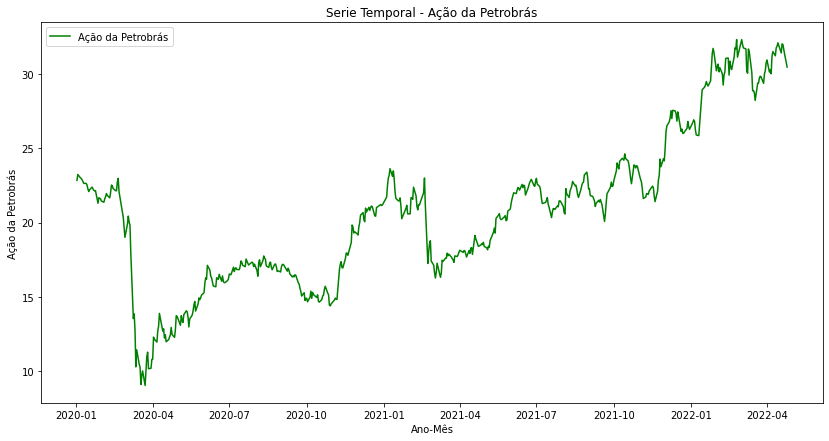

In [183]:
# Plot da Série Temporal
plt.figure(figsize=(14, 7))
plt.title("Serie Temporal - Ação da Petrobrás")
plt.plot(target, label = "Ação da Petrobrás", color = 'green')
plt.xlabel("Ano-Mês")
plt.ylabel("Ação da Petrobrás")
plt.legend(loc = "best");

**Série aparenta ter sazonalidade e tendência**

<AxesSubplot:xlabel='ano'>

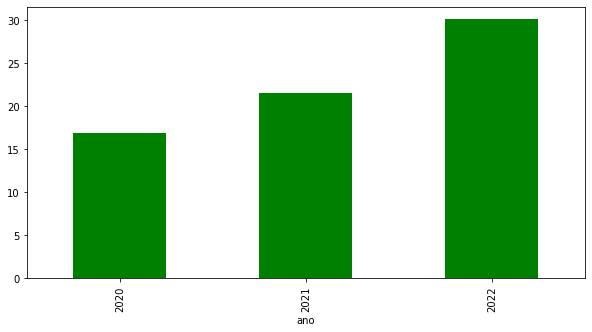

In [184]:
# Vamos criar um gráfico de barras com grafico por ano. 
plt.figure(figsize=(10, 5))
petr4.groupby('ano')['High'].mean().plot.bar(color = 'green')

**Tendência clara de alta**

In [185]:
import plotly.express as px
mes = petr4[['mes','High','ano']]
mes = pd.DataFrame(mes.groupby(["ano", "mes"])["High"].mean())
mes = mes.reset_index('mes')
px.line(mes[0:24], y='High', color='mes',labels = [['2020','2021']])

**Note que o meses 3 e 4 tem a maior distância entre o mês 12**

<AxesSubplot:xlabel='mes'>

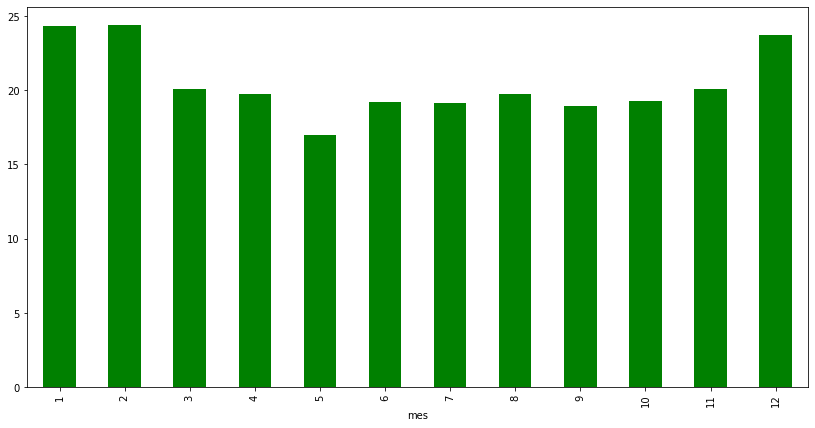

In [186]:
# Vamos criar um gráfico de barras por mês. 
plt.figure(figsize=(14, 7))
petr4.groupby('mes')['High'].mean().plot.bar(color = 'green')

**Os meses de dezembro a fevereiro são os que tem o maior índice de alta**

In [187]:
dia = petr4[['dia','High','ano']]
dia = pd.DataFrame(dia.groupby(["ano", "dia"])["High"].mean())
dia = dia.reset_index('dia')
px.line(dia, y='High', color='dia',labels = [['2020','2021','2020']])

**Observe que o dia 5 de qualquer mês, está com o valor sempre abaixo do dia 14 do mesmo mês**

In [188]:
dia = petr4[['dia','High','mes']]
dia = pd.DataFrame(dia.groupby(["mes", "dia"])["High"].mean())
dia = dia.reset_index('dia')
px.line(dia, y='High', color='dia',labels = [['2020','2021','2020']])

**Veja que no mês 4 é o periodo onde tem mais sazonalidade entre os dias**

<AxesSubplot:xlabel='dia'>

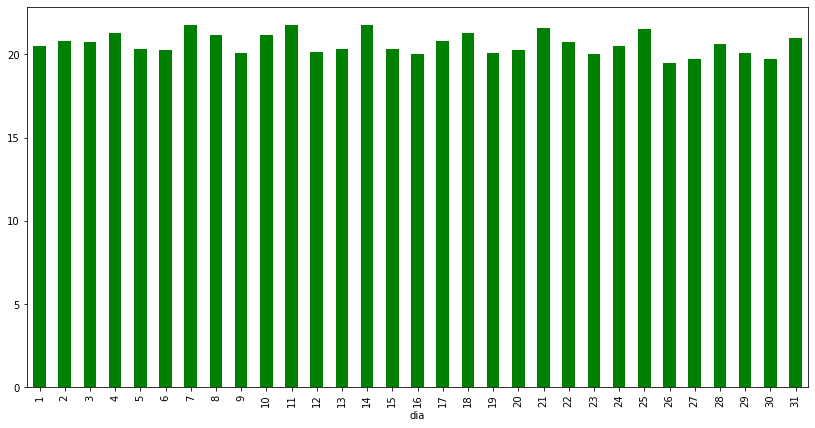

In [189]:
# A média diária por dia do mês
plt.figure(figsize=(14, 7))
petr4.groupby('dia')['High'].mean().plot.bar(color = 'green')

**Os dias do mês não parece ser relevante para este grafico**

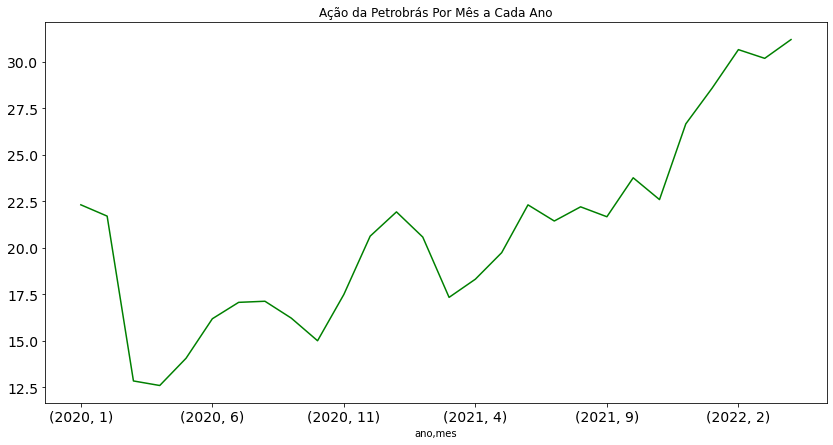

In [190]:
# Calcular a média mensal por ano
plt.figure(figsize=(14, 7))
media_mensal = petr4.groupby(['ano','mes'])['High'].mean()
media_mensal.plot(title = "Ação da Petrobrás Por Mês a Cada Ano", fontsize = 14, color = 'green');

**Tendência de alta com o passar dos meses**

### Modelo Aditivo (sazonalidade constante) X Modelo Multiplicativo (sazonalidade crescente)

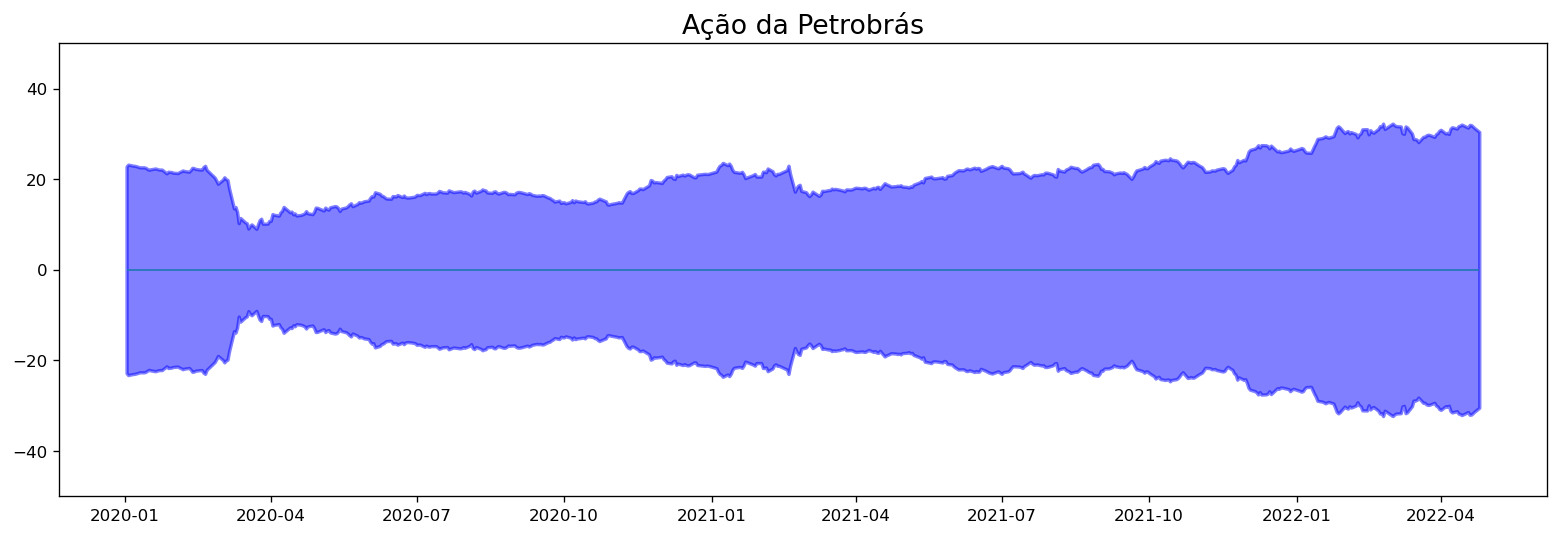

In [191]:
#Grafico de linha para verificar a variação nos dados em relação ao tempo

# Prepara os dados
x = petr4.index.values
y1 = petr4['High'].values


# Plot

# Área de plotagem
fig, ax = plt.subplots(1, 1, figsize = (16,5), dpi = 120)

# Preenchimento do gráfico
plt.fill_between(x, y1 = y1, y2 = -y1, alpha = 0.5, linewidth = 2, color = 'blue')


# Limites do eixo y
plt.ylim(-50, 50)


# Título
plt.title('Ação da Petrobrás', fontsize = 16)


# Limite das linhas
plt.hlines(y = 0, xmin = np.min(petr4.index), xmax = np.max(petr4.index), linewidth = 1);


# Mostra o gráfico
plt.show()

**A Série Temporal não tem uma clareza nos dados para saber se a sazonalidade é aditiva ou multiplicativa, o correto é testar as 2 formas**

## Verificar a estacionaridade da série

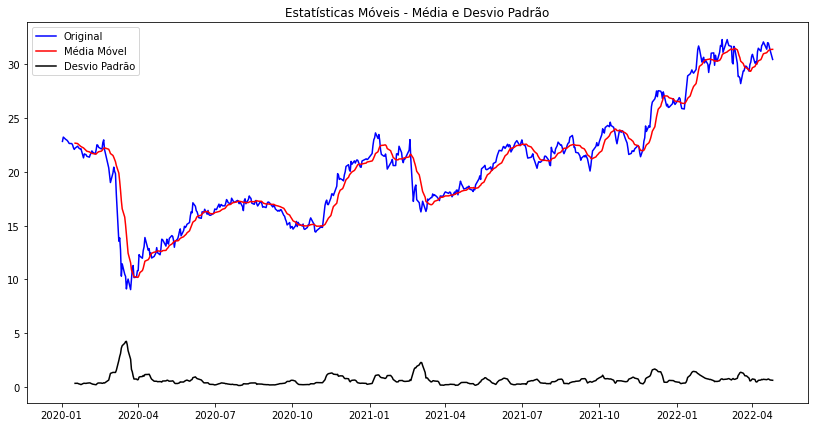


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -1.225024
Valor-p                           0.662740
Número de Lags Consideradas       7.000000
Número de Observações Usadas    564.000000
Valor Crítico (1%)               -3.441998
Valor Crítico (5%)               -2.866678
Valor Crítico (10%)              -2.569506
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [192]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    plt.figure(figsize=(14, 7))
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')
        

testa_estacionaridade(petr4.High)

## Pré-Processamento

- **IMPORTANTE:** Para Modelos ARIMA, devemos remover a tendência, por isso sempre aplicamos diferenciação para as séries não estacionarias e transformamos os dados em Log natural para reduzir o efeito dos ruídos e deixar os dados com distribuição normal ou próximo dela

## 1° - Transformação de Log


- Séries temporais com uma distribuição exponencial podem ser linearizadas usando o logaritmo dos valores


- É importante observar que esta operação assume que os valores são positivos e diferentes de zero

In [193]:
# Aplicando transformação de log
df_log = np.log(petr4.High) 
df_log

Date
2020-01-02    3.127957
2020-01-03    3.145393
2020-01-06    3.135744
2020-01-07    3.133803
2020-01-08    3.130234
                ...   
2022-04-18    3.446489
2022-04-19    3.465736
2022-04-20    3.464172
2022-04-22    3.443618
2022-04-25    3.415758
Name: High, Length: 572, dtype: float64

**Aplicando transformação de log para deixar os dados perto de uma distribuição normal e mais lineares**

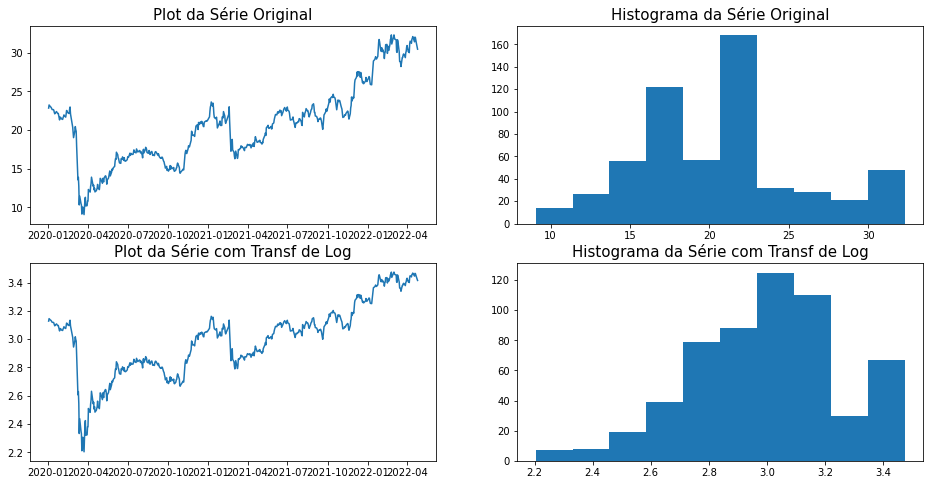

In [194]:
# Plot
fig, axes = plt.subplots(2, 2,figsize=(16,8))
axes[0,0].plot(petr4.High); axes[0, 0].set_title('Plot da Série Original',fontsize=15)
axes[0,1].hist(petr4.High); axes[0, 1].set_title('Histograma da Série Original',fontsize=15) 

axes[1,0].plot(df_log); axes[1, 0].set_title('Plot da Série com Transf de Log',fontsize=15) 
axes[1,1].hist(df_log); axes[1, 1].set_title('Histograma da Série com Transf de Log',fontsize=15) 

plt.show()

In [195]:
### Normalidade da Série

#P_value > 0.05 = dados normalizados

from scipy import stats
shapiro_test_orig = stats.shapiro(petr4.High)[1]
shapiro_test_log = stats.shapiro(df_log)[1]

print(f'Teste Shapiro dados Originais:  {round(shapiro_test_orig,5)}')
print(f'Teste Shapiro dados com log: {round(shapiro_test_log,5)}')

Teste Shapiro dados Originais:  0.0
Teste Shapiro dados com log: 0.0


**Observamos que após aplicar o log na série, o valor dos dados ficam em uma escala menor, porém a distribuição continua não sendo normal**

# Diferenciação(Lag)


- O processo de diferenciação pode ser repetido mais de uma vez até que toda a tendência seja removida.


- 1° diferenciação normalmente elimina a tendência da série e a 2° diferenciação elimina a sazonalidade

In [196]:
# Diferenciação de 1° Ordem
df_log_diff1 = df_log - df_log.shift(1)
df_log_diff1.dropna(inplace = True)
df_log_diff1

Date
2020-01-03    0.017437
2020-01-06   -0.009649
2020-01-07   -0.001941
2020-01-08   -0.003569
2020-01-09   -0.004887
                ...   
2022-04-18   -0.021432
2022-04-19    0.019247
2022-04-20   -0.001564
2022-04-22   -0.020554
2022-04-25   -0.027861
Name: High, Length: 571, dtype: float64

In [197]:
# Diferenciação de 2° Ordem
df_log_diff2 = df_log - df_log.shift(2)
df_log_diff2.dropna(inplace = True)
df_log_diff2

Date
2020-01-06    0.007787
2020-01-07   -0.011590
2020-01-08   -0.005510
2020-01-09   -0.008455
2020-01-10   -0.010783
                ...   
2022-04-18   -0.014176
2022-04-19   -0.002185
2022-04-20    0.017683
2022-04-22   -0.022118
2022-04-25   -0.048415
Name: High, Length: 570, dtype: float64

**Aplicamos diferenciação nos dados com transformação de Log para tornar a série estacionária e deixar a distribuição proxima ou normalizada**

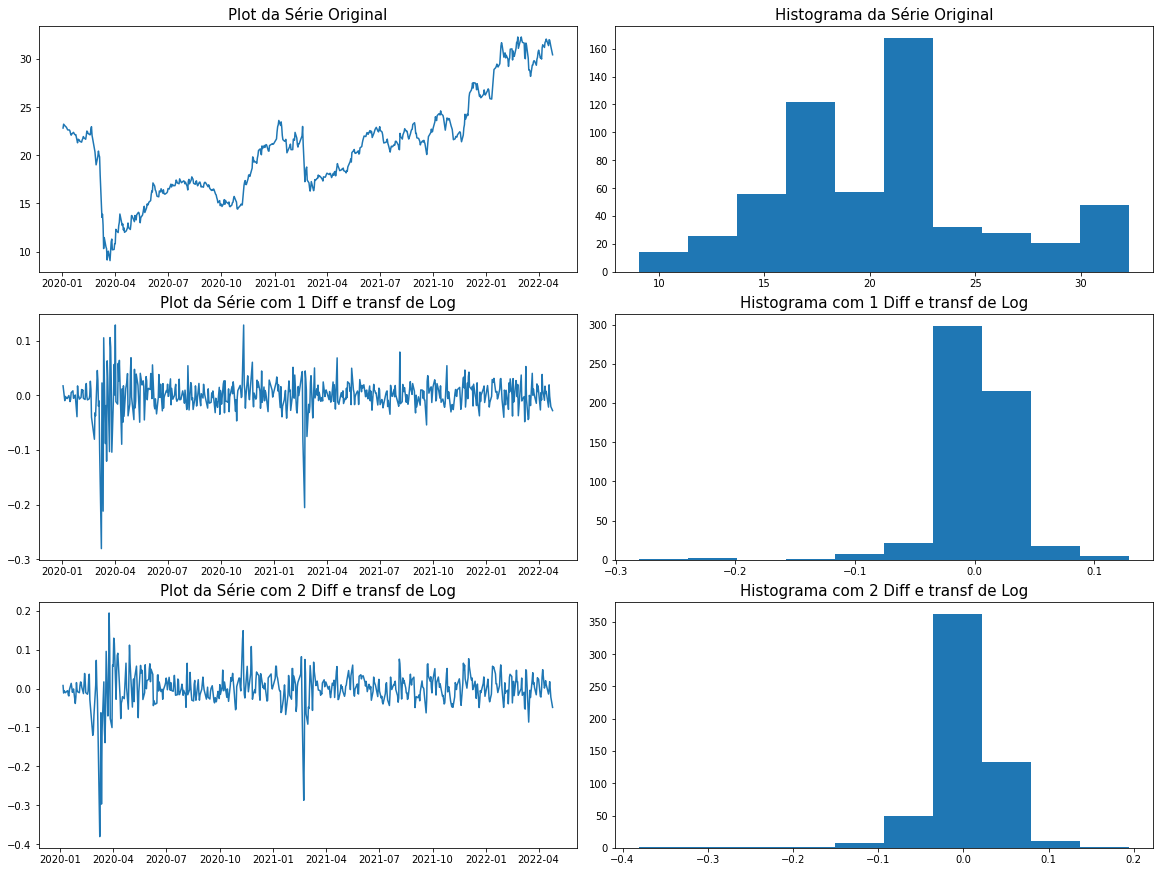

In [198]:
# Grafico de Plot e histograma da série original e com diferenciações
fig, axes = plt.subplots(3, 2,figsize=(16,12),constrained_layout=True)
axes[0,0].plot(petr4.High); axes[0, 0].set_title('Plot da Série Original',fontsize=15)
axes[0,1].hist(petr4.High); axes[0, 1].set_title('Histograma da Série Original',fontsize=15)
axes[1,0].plot(df_log_diff1); axes[1, 0].set_title('Plot da Série com 1 Diff e transf de Log',fontsize=15)
axes[1,1].hist(df_log_diff1); axes[1, 1].set_title('Histograma com 1 Diff e transf de Log',fontsize=15)
axes[2,0].plot(df_log_diff2); axes[2, 0].set_title('Plot da Série com 2 Diff e transf de Log',fontsize=15)
axes[2,1].hist(df_log_diff2); axes[2, 1].set_title('Histograma com 2 Diff e transf de Log',fontsize=15)
plt.show()

**Note que a série original não tem uma distribuição normal e os dados não são estacionários, porém ao aplicar 1 e 2 diffs os dados aparenta ficar com distribuição normal e com Estacionaridade**

In [199]:
### Teste de normalidade da Série

#P_value > 0.05 = dados normalizados

from scipy import stats
shapiro_test_orig = stats.shapiro(petr4.High)[1]
shapiro_test_log1 = stats.shapiro(df_log_diff1)[1]
shapiro_test_log2 = stats.shapiro(df_log_diff2)[1]

print(f'Teste Shapiro dados Originais:  {round(shapiro_test_orig,5)}')
print(f'Teste Shapiro dados com log e 1 Diff: {round(shapiro_test_log1,5)}')
print(f'Teste Shapiro dados com log e 2 Diff: {round(shapiro_test_log2,5)}')

Teste Shapiro dados Originais:  0.0
Teste Shapiro dados com log e 1 Diff: 0.0
Teste Shapiro dados com log e 2 Diff: 0.0


**Tanto a série original quanto as séries com diferenciações não apresentam estatisticamente distribuição normal dos dados, apesar de graficamente os dados se mostrarem bem próximos a uma distribuição normal**

- ### Aplicar a função para checar a estacionaridade 

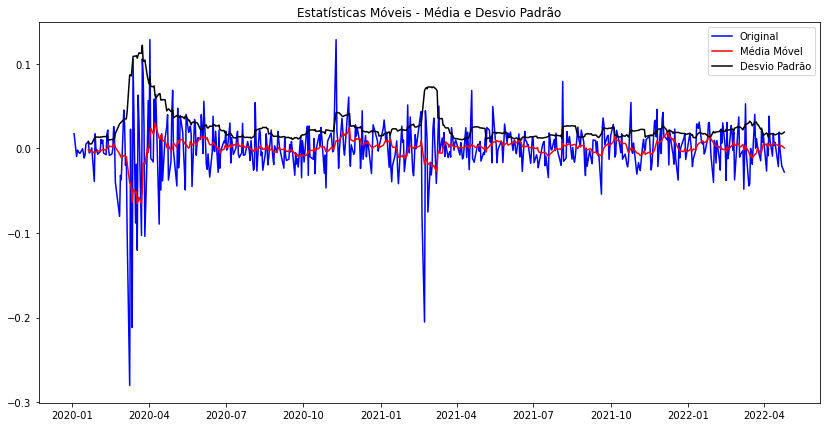


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -6.716697e+00
Valor-p                         3.567087e-09
Número de Lags Consideradas     6.000000e+00
Número de Observações Usadas    5.640000e+02
Valor Crítico (1%)             -3.441998e+00
Valor Crítico (5%)             -2.866678e+00
Valor Crítico (10%)            -2.569506e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [200]:
#função para checar a estacionaridade 1 diff
teste_log_diff1 = df_log_diff1.dropna() #Excluir os dados NAN gerado pelo diff
testa_estacionaridade(teste_log_diff1)

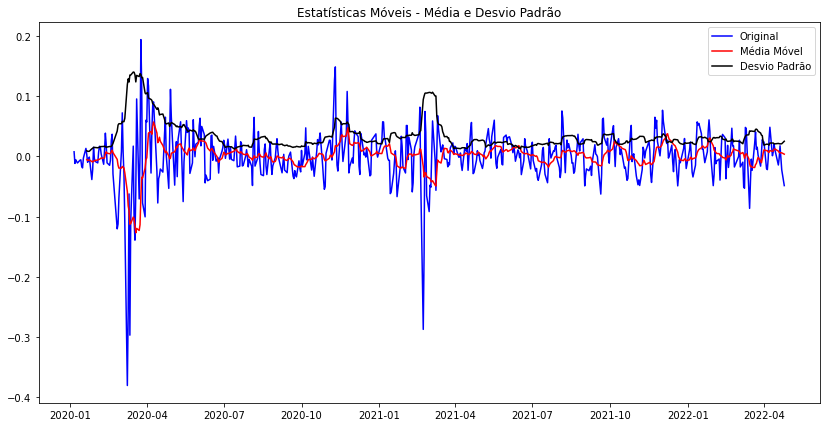


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -6.295354e+00
Valor-p                         3.516878e-08
Número de Lags Consideradas     1.300000e+01
Número de Observações Usadas    5.560000e+02
Valor Crítico (1%)             -3.442166e+00
Valor Crítico (5%)             -2.866752e+00
Valor Crítico (10%)            -2.569546e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [201]:
#função para checar a estacionaridade 2 diff
teste_log_diff2 = df_log_diff2.dropna() #Excluir os dados NAN gerado pelo diff
testa_estacionaridade(teste_log_diff2)

**Série Temporal estacionária com 1 ou 2 diffs**

**OBS: Após realizar as etapas de transformação de Log e diferenciação, chegou a hora de descobrir os melhores coeficientes do modelo ARIMA (p,d,q)**

 # Parâmetros ARIMA:

**Um modelo ARIMA requer 3 parâmetros:**

- param p: (int) Ordem do modelo de AR.
- param d: (int) Número de vezes que os dados precisam ser diferenciados.
- param q: (int) Ordem do modelo MA.

 ## 1° Determinando o Valor do Parâmetro d (I) para o Modelo ARIMA

- ### Diferenciação:

- O objetivo da diferenciação é tornar a série temporal estacionária. 


- A ordem correta de diferenciação é a diferenciação mínima necessária para obter uma série quase estacionária que circula em torno de uma média definida e o gráfico ACF chega a zero rapidamente.


- Se as autocorrelações forem positivas para muitos atrasos (10 ou mais), a série precisará ser diferenciada. Por outro lado, se a autocorrelação lag 1 em si for muito negativa, a série provavelmente será super diferenciada.



- Se não for possível realmente decidir entre duas ordens de diferenciação, então escolha a ordem que apresenta o menor desvio padrão na série diferenciada.

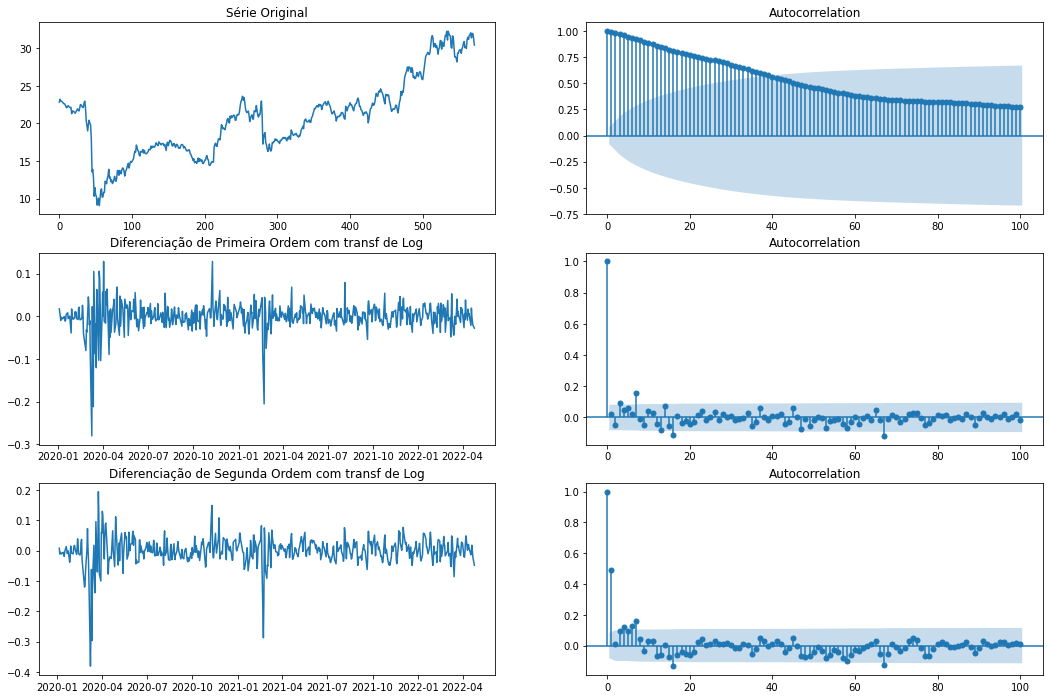

In [202]:
#Plot X autocorrelação da série original e com transformação de Log e diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Área de Plotagem
fig, axes = plt.subplots(3, 2,figsize=(18,12))

# Série Original
axes[0, 0].plot(target.values); axes[0, 0].set_title('Série Original')
plot_acf(target.values, lags = 100, ax = axes[0, 1])


# Diferenciação de Primeira Ordem e transformação de Log
axes[1, 0].plot(df_log_diff1); axes[1, 0].set_title('Diferenciação de Primeira Ordem com transf de Log')
plot_acf(df_log_diff1, lags = 100, ax = axes[1, 1])


# Diferenciação de Segunda Ordem e transformação de Log
axes[2, 0].plot(df_log_diff2); axes[2, 0].set_title('Diferenciação de Segunda Ordem com transf de Log')
plot_acf(df_log_diff2, lags = 100, ax = axes[2, 1])


plt.show()

**Veja que a série original tem um decaimento lento das lags na autocorrelação, indicando uma alta correlação com os primeiros 40 lags, já com os dados com a Transformação logaritimica e com diff de 1° e 2° ordem as correlações se aplicam somente no inicio das séries, portanto teremos que testar os melhores parametros de diferenciação com os valores 1 e 2**

In [203]:
# Teste KPSS, indica quantos diferenciação é necessaria para tornar os dados estacionarios
from pmdarima.arima.utils import ndiffs

ndiffs(target, test = 'kpss')  

1

**O teste KPSS é uma ajuda para indicar o menor numero de diferenciação necessaria para tornar a série estacionaria, porém para modelagem é necessario outros parâmetros que em combinação com a diferenciação pode dar um valor diferente do teste**

- **Conclusão parâmetro I: Verificando a série original comparada com a série com log e diferenciada concluimos que o parametro I pode ser diferenciado 1 ou 2 vez para deixar a série estacionaria. Agora vamos encontrar o termo AR, com o parâmetro p**

 ## 2° Determinando o Valor do Parâmetro AR(p) para o Modelo ARIMA

- ### Auto Regressivo:

- Usar o graficos PAC para descobrir o número necessário de termos AR


- A autocorrelação parcial pode ser imaginada como a correlação entre a série e seu atraso, após excluir as contribuições dos atrasos intermediários. Portanto, o PACF meio que transmite a correlação pura entre um atraso e a série. Dessa forma, você saberá se esse atraso é necessário no termo AR ou não


- Qualquer autocorrelação em uma série estacionarizada pode ser retificada adicionando termos AR suficientes. Portanto, inicialmente consideramos a ordem do termo AR igual a tantas defasagens que ultrapassam o limite de significância no gráfico PACF.

C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



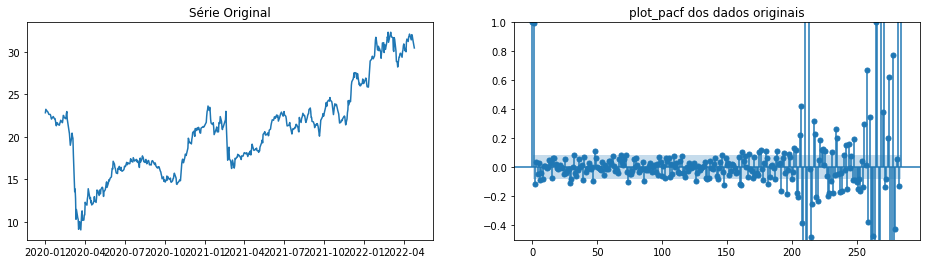

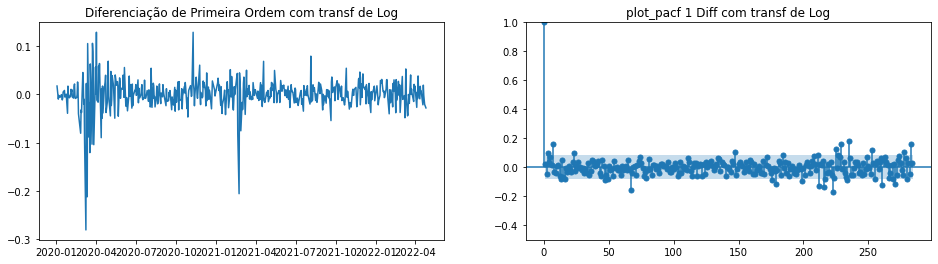

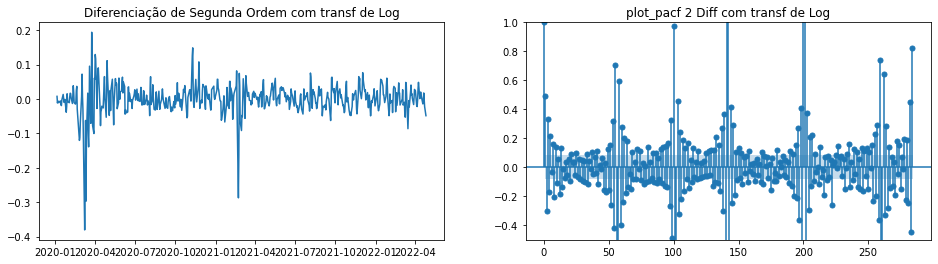

In [204]:
# Gráfico de plot X Autocorrelação parcial da série original e com transformação de Log e diff

from pandas.plotting import autocorrelation_plot
fig, axes = plt.subplots(1, 2,figsize=(16,4))
axes[0].plot(target); axes[0].set_title('Série Original')
axes[1].set(ylim = (-0.5,1))
plot_pacf(target.values, lags = 284, ax = axes[1]);axes[1].set_title('plot_pacf dos dados originais')



fig, axes = plt.subplots(1, 2,figsize=(16,4))
axes[0].plot(df_log_diff1); axes[0].set_title('Diferenciação de Primeira Ordem com transf de Log')
axes[1].set(ylim = (-0.5,1))
plot_pacf(df_log_diff1, lags = 284, ax = axes[1]);axes[1].set_title('plot_pacf 1 Diff com transf de Log')




fig, axes = plt.subplots(1, 2,figsize=(16,4))
axes[0].plot(df_log_diff2); axes[0].set_title('Diferenciação de Segunda Ordem com transf de Log')
axes[1].set(ylim = (-0.5,1))
plot_pacf(df_log_diff2, lags = 284, ax = axes[1]);axes[1].set_title('plot_pacf 2 Diff com transf de Log')

plt.show()

**No grafico original percebemos uma forte autocorrelação nos ultimos Lags, já na diferenciação de Primeira Ordem com transf de Log há poucos dados com autocorrelação forte durante a série, porém no grafico com diferenciação de Segunda Ordem com transf de Log praticamente toda a série tem autocorrelação, mostrando um ciclo com forte autocorrelação a cada 50 lags**

- **Conclusão parâmetro P: Verificando a série original comparada com a série diferenciada e transformada com Log natural, fica dificil encontrar um numero ideal do termo (AR), portanto para ter o melhor ajuste é necessario testar alguns valores**

## 3° Determinando o Valor do Parâmetro q para o Modelo ARIMA

- ### Média Movel:

- Usa as medias moveis para descobrir a melhor previsão com base nos residuos


-  Observar o gráfico ACF para o número de termos MA. Um termo MA é tecnicamente o erro da previsão atrasada


- O ACF informa quantos termos MA são necessários para remover qualquer autocorrelação na série estacionarizada


- Os modelos MA (q) tentam capturar os efeitos de choque observados em termos de ruído branco. Estes efeitos de choque podem ser considerados eventos inesperados que afetam o processo de observação, p, como ganhos repentinos, guerras, ataques, etc.


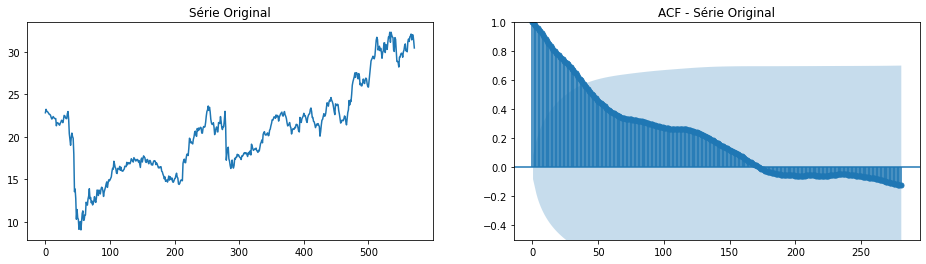

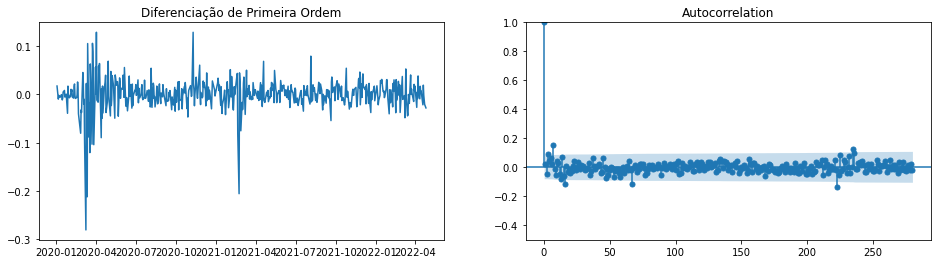

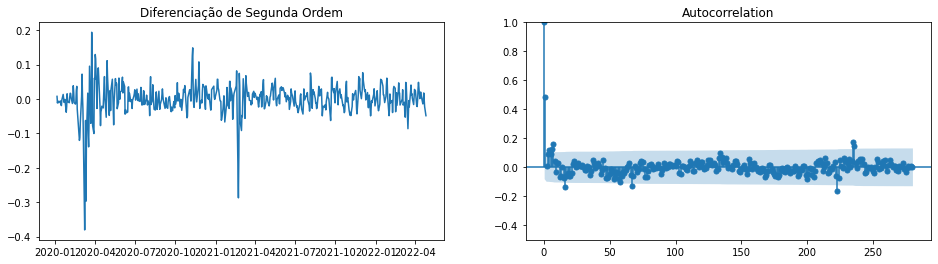

In [205]:
# Gráfico ACF

fig, axes = plt.subplots(1, 2,figsize=(16,4))
axes[0].plot(target.values); axes[0].set_title('Série Original')
axes[1].set(ylim = (-0.5,1))
plot_acf(target.values, lags = 280, ax = axes[1]);axes[1].set_title('ACF - Série Original')



fig, axes = plt.subplots(1, 2,figsize=(16,4))
axes[0].plot(df_log_diff1); axes[0].set_title('Diferenciação de Primeira Ordem')
axes[1].set(ylim = (-0.5,1))
plot_acf(df_log_diff1, ax = axes[1],lags = 280)



fig, axes = plt.subplots(1, 2,figsize=(16,4))
axes[0].plot(df_log_diff2); axes[0].set_title('Diferenciação de Segunda Ordem')
axes[1].set(ylim = (-0.5,1))
plot_acf(df_log_diff2, ax = axes[1],lags = 280)

plt.show()

**Observando os dados originais e os dados diferenciados e com transformação de Log, podemos concluir que em todos os casos a uma autocorrelação nos primeiros lags, sendo essa autocorrelação mais forte nos dados originais**

**Embora a autocorrelação se mostre forte nos dados originais, fica dificil definir um valor do termo (q) para o modelo ARIMA, sendo necessario testar alguns valores para conseguir encontrar o melhor modelo**

- ## 1° Dividir os dados em treino teste e validação

In [206]:
#Dividir os dados em treino e teste
df_treino = petr4.High.iloc[0:500]
df_teste = petr4.High.iloc[500:]

#Transformar os dados em Log Natural
df_treino_log = np.log(df_treino)
df_teste_log = np.log(df_teste)

#Aplicar diferenciação de 1° e 2° ordem nos dados de treino com log natural
df_treino_log_diff1 = df_treino_log - df_treino_log.shift(1)
df_treino_log_diff2 = df_treino_log - df_treino_log.shift(1)

#Aplicar diferenciação de 1° e 2° ordem nos dados de teste com log natural
df_teste_log_diff1 = df_teste_log - df_teste_log.shift(1)
df_teste_log_diff2 = df_teste_log - df_teste_log.shift(1)

In [207]:
#Dividir os dados de treino em validação também para treinar e validar a performance do modelo
df_treino_val = df_treino[0:420]
df_valid = df_treino[420:500]

#Transformar os dados de treino e validação em Log Natural
df_treino_val_log = np.log(df_treino_val)
df_valid_log = np.log(df_valid)

#Aplicar diferenciação de 1° e 2° ordem nos dados de treino com Log Natural
df_treino_val_log_diff1 = df_treino_val_log - df_treino_val_log.shift(1)
df_treino_val_log_diff2 = df_treino_val_log - df_treino_val_log.shift(2)

#Aplicar diferenciação de 1° e 2° ordem nos dados de validação com Log Natural
df_valid_log_diff1 = df_valid_log - df_valid_log.shift(1)
df_valid_log_diff2 = df_valid_log - df_valid_log.shift(2)

**No modelo ARIMA usamos os dados originais da série ou com transformação Logarítmica, pois determinamos os parâmetros dentro do algoritimo, portanto para comparar o modelo gerado com os dados originais, diferenciamos a série conforme o número de diferenciações que serão usadas na modelagem**

**Observe que a separação dos registros em um série temporal é feita com ordem cronológica**

# Modelo Sarima:

## Cria o 1° Modelo auto_arima:

In [208]:
# Buscando pela ordem ideal para o modelo
# A função pm.auto_arima aplica o Grid Search e retorna o melhor modelo
modelo_v1 = pm.auto_arima(df_treino_val_log,
                          seasonal = True, 
                          m = 12,
                          d = 0, 
                          D = 1, 
                          max_p = 2, 
                          max_q = 2,
                          trace = True,
                          error_action = 'ignore',
                          suppress_warnings = True) 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-424.065, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-1399.901, Time=0.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-845.903, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-426.059, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-1289.326, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-1439.371, Time=2.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.05 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-420.572, Time=0.60 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-1437.545, Time=2.85 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-1437.574, Time=3.06 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-845.449, Time=0.94 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-1442.351, Time=4.84 sec
 ARIMA(2,0,1)(1,1,0)[12] int

In [209]:
# Print do sumário do melhor modelo encontrado
print(modelo_v1.summary())


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  420
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood                 729.032
Date:                             Fri, 06 May 2022   AIC                          -1446.064
Time:                                     09:46:34   BIC                          -1421.996
Sample:                                          0   HQIC                         -1436.540
                                             - 420                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0950      0.069      1.385      0.166      -0.039       0.229
ar.L2          0.8530      

**Criamos o modelo base auto_arima para determinar os coeficientes iniciais do modelo SARIMAX**

## Cria o 2° Modelo SARIMAX:

In [210]:
# Cria o Modelo usando o algoritimo do SARIMAX
import warnings
warnings.filterwarnings('ignore')

modelo_sarima_v2 = sm.tsa.statespace.SARIMAX(df_treino_val_log,
                                             order = (2, 0, 1),
                                             seasonal_order = (2, 1,0, 12),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

# Treinamento (Fit) do modelo
modelo_sarima_v2_fit = modelo_sarima_v1.fit()

In [215]:
# Sumário do modelo
print(modelo_sarima_v2_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                High   No. Observations:                  420
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood                 656.135
Date:                             Fri, 06 May 2022   AIC                          -1300.269
Time:                                     09:55:51   BIC                          -1276.597
Sample:                                          0   HQIC                         -1290.878
                                             - 420                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1918      0.077      2.499      0.012       0.041       0.342
ar.L2          0.7431      

**Note que o valor do AIC teve uma redução considerável com os mesmos valores de parâmetros, apenas escolhendo o algoritimo SARIMAX ao invés do auto_arima**

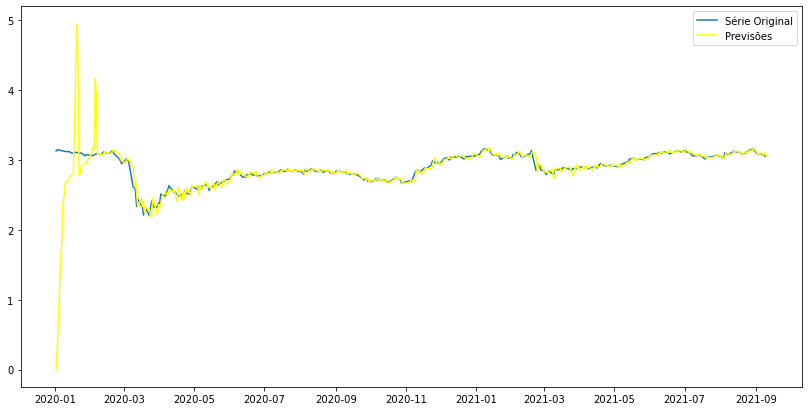

In [216]:
#Previsão dados de treino

#Dados reais x previsão
dados_reais = df_treino_val_log
previsoes = modelo_sarima_v2_fit.fittedvalues

# Plot
plt.figure(figsize=(14, 7))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes, color = 'yellow', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

**A Série se ajustou bem aos dados de treino**

## Forecast dados de validação

In [231]:
# Forecast - Definir o numero de periodos a frente para ser previsto 

forecast_2 = modelo_sarima_v2_fit.get_forecast(len(df_valid_log))


In [234]:
#Criar intervalo de confiança

#Criar intervalos de confiança minimo e maximo
prev2 = forecast_2.conf_int()

#Criar a media dos intervalos de confiança = previsão
prev2['Mean'] = forecast_2.predicted_mean

#Criar o indice
prev2.index = df_valid_log.index
prev2

,lower High,upper High,Mean
Date,,,
2021-09-13,2.977819,3.148126,3.062972
2021-09-14,2.946834,3.195102,3.070968
2021-09-15,2.942159,3.238170,3.090165
2021-09-16,2.927021,3.265987,3.096504
2021-09-17,2.911821,3.283087,3.097454
...,...,...,...
2022-01-03,2.090901,4.058696,3.074798
2022-01-04,2.077953,4.065223,3.071588
2022-01-05,2.044234,4.049968,3.047101


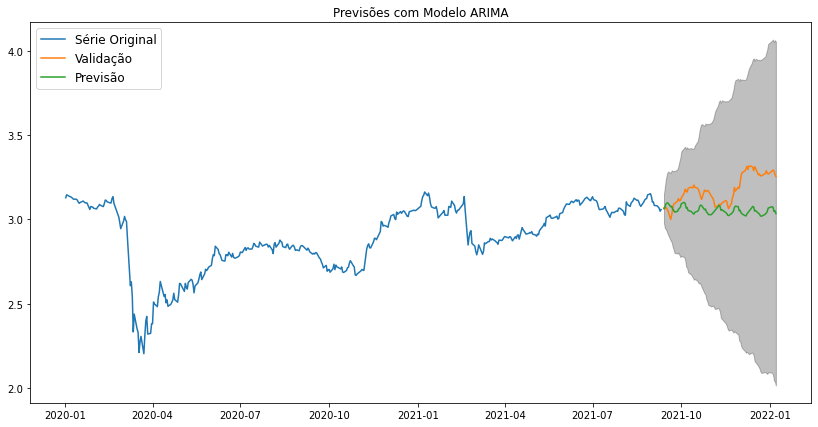

In [241]:
# Plot da Série Original, Validação e Previsão
plt.figure(figsize=(14, 7))
plt.plot(df_treino_val_log, label = 'Série Original')
plt.plot(df_valid_log, label = 'Validação')
plt.plot(prev2.Mean, label = 'Previsão')


plt.fill_between(prev2.index,
                prev2.iloc[:, 0],
                prev2.iloc[:, 1], color = 'k', alpha = .25)
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

**A previsão está com uma leve tendencia de baixa, enquanto os dados reais estão com tendencia de alta, já o intervalo de confiança está muito amplo, prejudicando assim a previsão**

## Análise dos Resíduos

In [423]:
#Média dos resíduos
modelo_sarima_v2_fit.resid.mean()

0.01981745167214091

**Média dos resíduos igual a zero**

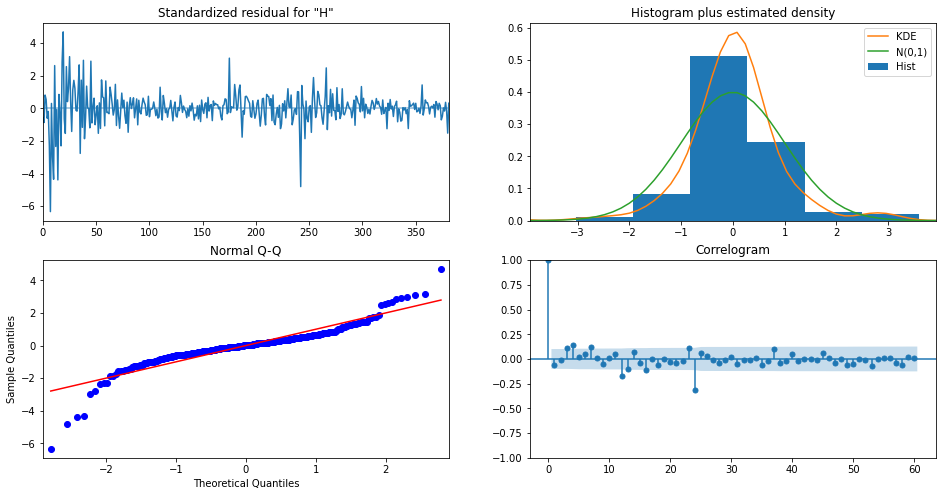

In [356]:
# Diagnóstico do modelo
modelo_sarima_v2_fit.plot_diagnostics(figsize = (16, 8),lags=60)
plt.show()

**Veja que o histograma e o gráfico QQ-plot está bem distante de uma distribuição normal, e há pontos no correlograma que aparenta ter autocorrelação entre os resíduos**

In [357]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_sarima_v2_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [1.2408097e-48]


**Observe que o valor-p é menor que 0.05, o que indica que os valores não são aleatórios e independentes ao longo do tempo a um nível de significância de 95% e, portanto, o modelo não fornece um bom ajuste**

# Criar 3° modelo com grid Search Métrica de erro: AIC

In [404]:
start = time()
import warnings
warnings.filterwarnings('ignore')

p_values = [0,1,2]
q_values = [0,1]
d_values = [0,1]
P_values = [0,1]
D_values = [0,1,2]
Q_values = [0,1]
m_values = [24]

dados_treino = df_treino_val_log
dados_teste = df_valid_log

melhor_AIC = -1200
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in q_values:
                        for m in m_values:
                            try:
                                modelo_ARIMA3 = sm.tsa.statespace.SARIMAX(df_treino_val_log,
                                                 order = (p, d, q),
                                                 seasonal_order = (P, D,Q, m),
                                                 enforce_stationarity = False,
                                                 enforce_invertibility = False)
                                modelo_v3 = modelo_ARIMA3.fit( disp = False)
                                fc = pd.DataFrame(modelo_v3.forecast(len(df_valid_log))) 
                                fc['data'] = df_valid_log.index
                                fc = fc.set_index('data')


                                y_true = df_valid_log
                                y_pred = fc

                                # Calcula o erro usando AIC (Root Mean Squared Error)
                                metrica_aic = modelo_v3.aic 
                                print(f'ARIMA{p, d, q , P, D ,Q, m} AIC= {metrica_aic} ')
                                if metrica_aic < melhor_AIC and metrica_aic < 0:
                                    melhor_AIC = metrica_aic
                                    melhor_order = (p, d, q , P, D ,Q, m)
                                    melhor_modelo = modelo_v3
                                else:
                                    melhor_AIC = melhor_AIC
                                    melhor_order = melhor_order
                                    melhor_modelo = melhor_modelo
                                    
                            except:continue
                                
                                
                                
                            
# Print
print('\nMelhor Valor de AIC: %6.2f | order: %s'%(melhor_AIC, melhor_order))
print('\nMelhor Modelo:', melhor_modelo.summary())

#Tempo de execução do modelo
time1 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

ARIMA(0, 0, 0, 0, 0, 0, 24) AIC= 2082.680312211355 
ARIMA(0, 0, 0, 0, 0, 1, 24) AIC= 1518.9634069521317 
ARIMA(0, 0, 0, 0, 1, 0, 24) AIC= -123.29595802169374 
ARIMA(0, 0, 0, 0, 1, 1, 24) AIC= -128.33442183012426 
ARIMA(0, 0, 0, 0, 2, 0, 24) AIC= 172.5990663776612 
ARIMA(0, 0, 0, 0, 2, 1, 24) AIC= -129.0986646004719 
ARIMA(0, 0, 0, 1, 0, 0, 24) AIC= -123.06199450433533 
ARIMA(0, 0, 0, 1, 0, 1, 24) AIC= -165.34807691707448 
ARIMA(0, 0, 0, 1, 1, 0, 24) AIC= -111.179877923189 
ARIMA(0, 0, 0, 1, 1, 1, 24) AIC= -203.86888350587947 
ARIMA(0, 0, 0, 1, 2, 0, 24) AIC= -0.9717909237512998 
ARIMA(0, 0, 0, 1, 2, 1, 24) AIC= -76.44765248588806 
ARIMA(0, 0, 1, 0, 0, 0, 24) AIC= 1511.4341380092076 
ARIMA(0, 0, 1, 0, 0, 1, 24) AIC= 982.946445956363 
ARIMA(0, 0, 1, 0, 1, 0, 24) AIC= -564.4129986713601 
ARIMA(0, 0, 1, 0, 1, 1, 24) AIC= -574.0810729093289 
ARIMA(0, 0, 1, 0, 2, 0, 24) AIC= -220.51592472013138 
ARIMA(0, 0, 1, 0, 2, 1, 24) AIC= -510.0088763402782 
ARIMA(0, 0, 1, 1, 0, 0, 24) AIC= -566.811779

In [405]:
#Melhor valor do AIC
melhor_AIC

-1627.1519565718597

In [406]:
#Melhores parâmteros
melhor_order

(1, 0, 0, 0, 0, 0, 24)

In [407]:
# Cria o Modelo SARIMA
modelo_sarima_v3 = sm.tsa.statespace.SARIMAX(df_treino_val_log,
                                             order = (1, 0, 0),
                                             seasonal_order = (0, 0,0, 24),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

# Treinamento (Fit) do modelo
modelo_sarima_v3_fit = modelo_sarima_v3.fit()
modelo_sarima_v3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                  420
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 815.576
Date:                Fri, 06 May 2022   AIC                          -1627.152
Time:                        14:47:17   BIC                          -1619.076
Sample:                             0   HQIC                         -1623.960
                                - 420                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.001   1389.287      0.000       0.998       1.001
sigma2         0.0012   3.14e-05     38.015      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              5420.16
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -2.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

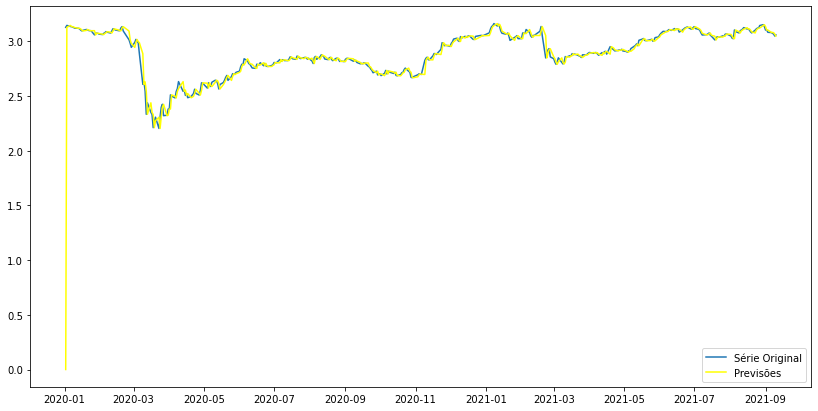

In [408]:
#Dados reais x previsão
dados_reais = df_treino_val_log
previsoes = modelo_sarima_v3_fit.fittedvalues

# Plot
plt.figure(figsize=(14, 7))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes, color = 'yellow', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

**A Série se ajustou bem aos dados de treino**

## Forecast dados de validação

In [409]:
# Forecast - Definir o numero de periodos a frente para ser previsto 

forecast_3 = modelo_sarima_v3_fit.get_forecast(len(df_valid_log))

In [410]:
#Criar intervalo de confiança

#Criar intervalos de confiança minimo e maximo
prev3 = forecast_3.conf_int()

#Criar a media dos intervalos de confiança = previsão
prev3['Mean'] = forecast_3.predicted_mean

#Criar o indice
prev3.index = df_valid_log.index
prev3

,lower High,upper High,Mean
Date,,,
2021-09-13,2.990074,3.125497,3.057785
2021-09-14,2.961628,3.153133,3.057381
2021-09-15,2.939711,3.174241,3.056976
2021-09-16,2.921174,3.191968,3.056571
2021-09-17,2.904798,3.207535,3.056167
...,...,...,...
2022-01-03,2.440194,3.614953,3.027573
2022-01-04,2.435980,3.618365,3.027172
2022-01-05,2.431792,3.621751,3.026772


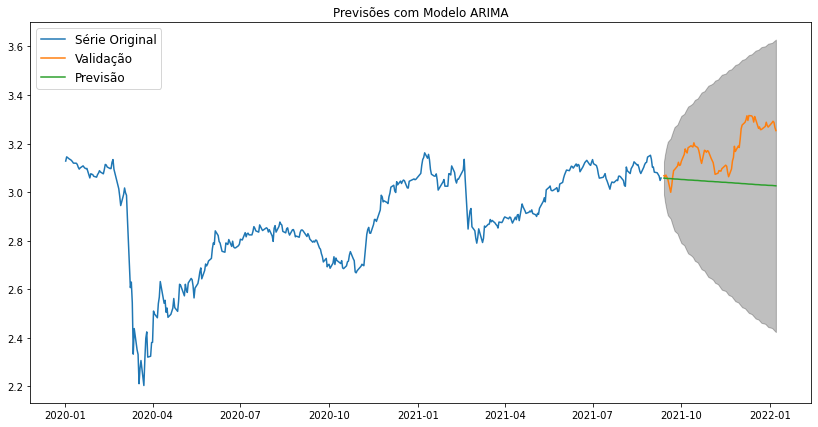

In [411]:
# Plot da Série Original, Validação e Previsão
plt.figure(figsize=(14, 7))
plt.plot(df_treino_val_log, label = 'Série Original')
plt.plot(df_valid_log, label = 'Validação')
plt.plot(prev3.Mean, label = 'Previsão')


plt.fill_between(prev3.index,
                prev3.iloc[:, 0],
                prev3.iloc[:, 1], color = 'k', alpha = .25)
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

**A direção da tendencia da previsão ainda continua errada, porém o intervalo de confiança está bem mais ajustado do que no modelo 2**

## Analise dos Resíduos

In [424]:
#Média dos resíduos
modelo_sarima_v3_fit.resid.mean()

0.007663242280680173

**Média dos resíduos igual a Zero**

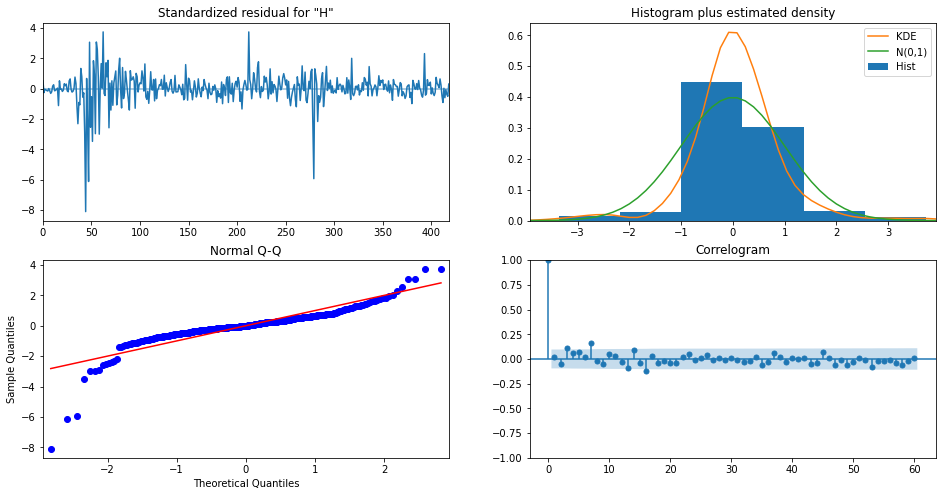

In [412]:
# Diagnóstico do modelo
modelo_sarima_v3_fit.plot_diagnostics(figsize = (16, 8),lags=60)
plt.show()

**Os resíduos não aparentam ter dados normalmente distribuídos e o gráfico de correlograma apresenta autocorrelação no início dos Lags**

In [413]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_sarima_v3_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [1.]


**Observe que o valor-p é maior que 0,05, o que indica que os valores são aleatórios e independentes ao longo do tempo em um nível de significância de 95% e, portanto, o modelo SARIMAX (1, 0, 0, 0, 0, 0, 12) fornece um bom ajuste do modelo**

# Criar 4° modelo com grid Search Métrica de erro: RMSE

In [383]:
start = time()
import warnings
warnings.filterwarnings('ignore')

p_values = [0,1,2]
q_values = [0,1]
d_values = [0,1]
P_values = [0,1]
D_values = [0,1,2]
Q_values = [0,1]
m_values = [12,24]

dados_treino = df_treino_val_log
dados_teste = df_valid_log

melhor_RMSE = 10
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in q_values:
                        for m in m_values:
                            try:
            
    
                                modelo_ARIMA3 = sm.tsa.statespace.SARIMAX(df_treino_val_log,
                                                 order = (p, d, q),
                                                 seasonal_order = (P, D,Q, m),
                                                 enforce_stationarity = False,
                                                 enforce_invertibility = False)
                                modelo_v3 = modelo_ARIMA3.fit( disp = False)
                                fc = pd.DataFrame(modelo_v3.forecast(len(df_valid_log))) 
                                fc['data'] = df_valid_log.index
                                fc = fc.set_index('data')


                                y_true = df_valid_log
                                y_pred = fc

                                # Calcula o erro usando RMSE (Root Mean Squared Error)
                                metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
                                print(f'ARIMA{p, d, q , P, D ,Q, m} RMSE= {metrica_rmse} ')
                                if metrica_rmse < melhor_RMSE:
                                    melhor_RMSE = metrica_rmse
                                    melhor_order = (p, d, q , P, D ,Q, m)
                                    melhor_modelo = modelo_v3
                                else:
                                    melhor_RMSE = melhor_RMSE
                                    melhor_order = melhor_order
                                    melhor_modelo = melhor_modelo
                                    
                            except: continue

                            
# Print
print('\nMelhor Valor de RMSE: %6.2f | order: %s'%(melhor_RMSE, melhor_order))
print('\nMelhor Modelo:', melhor_modelo.summary())

#Tempo de execução do modelo
time1 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

ARIMA(0, 0, 0, 0, 0, 0, 12) RMSE= 3.1766106490882966 
ARIMA(0, 0, 0, 0, 0, 0, 24) RMSE= 3.1766106490882966 
ARIMA(0, 0, 0, 0, 0, 1, 12) RMSE= 3.0068891294898337 
ARIMA(0, 0, 0, 0, 0, 1, 24) RMSE= 2.8012709671032066 
ARIMA(0, 0, 0, 0, 1, 0, 12) RMSE= 0.11746713652818035 
ARIMA(0, 0, 0, 0, 1, 0, 24) RMSE= 0.11541186176679297 
ARIMA(0, 0, 0, 0, 1, 1, 12) RMSE= 0.11754782131641806 
ARIMA(0, 0, 0, 0, 1, 1, 24) RMSE= 0.13978385253895276 
ARIMA(0, 0, 0, 0, 2, 0, 12) RMSE= 0.19448811630650417 
ARIMA(0, 0, 0, 0, 2, 0, 24) RMSE= 0.12022199651610396 
ARIMA(0, 0, 0, 0, 2, 1, 12) RMSE= 0.11983845049941744 
ARIMA(0, 0, 0, 0, 2, 1, 24) RMSE= 0.11537428973569956 
ARIMA(0, 0, 0, 1, 0, 0, 12) RMSE= 0.13300010157551512 
ARIMA(0, 0, 0, 1, 0, 0, 24) RMSE= 0.131151694076833 
ARIMA(0, 0, 0, 1, 0, 1, 12) RMSE= 0.13323452113367726 
ARIMA(0, 0, 0, 1, 0, 1, 24) RMSE= 0.10509280991575355 
ARIMA(0, 0, 0, 1, 1, 0, 12) RMSE= 0.1175414553172834 
ARIMA(0, 0, 0, 1, 1, 0, 24) RMSE= 0.11666831279736557 
ARIMA(0, 0, 0, 1,

ARIMA(1, 1, 0, 0, 1, 1, 24) RMSE= 0.14812453254940475 
ARIMA(1, 1, 0, 0, 2, 0, 12) RMSE= 1.2602241482168641 
ARIMA(1, 1, 0, 0, 2, 0, 24) RMSE= 0.12121920291114972 
ARIMA(1, 1, 0, 0, 2, 1, 12) RMSE= 0.3513739548577962 
ARIMA(1, 1, 0, 0, 2, 1, 24) RMSE= 0.17538256322829643 
ARIMA(1, 1, 0, 1, 0, 0, 12) RMSE= 0.14340802786096477 
ARIMA(1, 1, 0, 1, 0, 0, 24) RMSE= 0.14434838552273152 
ARIMA(1, 1, 0, 1, 0, 1, 12) RMSE= 0.14340981204682537 
ARIMA(1, 1, 0, 1, 0, 1, 24) RMSE= 0.15028514809003715 
ARIMA(1, 1, 0, 1, 1, 0, 12) RMSE= 0.23250987023767883 
ARIMA(1, 1, 0, 1, 1, 0, 24) RMSE= 0.19730977598830254 
ARIMA(1, 1, 0, 1, 1, 1, 12) RMSE= 0.13914819930003713 
ARIMA(1, 1, 0, 1, 1, 1, 24) RMSE= 0.13221087483969088 
ARIMA(1, 1, 0, 1, 2, 0, 12) RMSE= 0.9142436415008037 
ARIMA(1, 1, 0, 1, 2, 0, 24) RMSE= 0.3407826040435641 
ARIMA(1, 1, 0, 1, 2, 1, 12) RMSE= 0.2321340062622981 
ARIMA(1, 1, 0, 1, 2, 1, 24) RMSE= 0.07051486937387098 
ARIMA(1, 1, 1, 0, 0, 0, 12) RMSE= 0.1443626653844331 
ARIMA(1, 1, 1, 0

In [414]:
#Melhor valor do RMSE
melhor_RMSE

0.061874318083144794

In [415]:
#Melhores parâmteros
melhor_order

(1, 0, 0, 0, 0, 0, 24)

In [416]:
# Cria o Modelo SARIMA
modelo_sarima_v4 = sm.tsa.statespace.SARIMAX(df_treino_val_log,
                                             order = (1, 0, 0),
                                             seasonal_order = (1, 0,1, 24),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

# Treinamento (Fit) do modelo
modelo_sarima_v4_fit = modelo_sarima_v4.fit()
modelo_sarima_v4_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 High   No. Observations:                  420
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 24)   Log Likelihood                 776.720
Date:                              Fri, 06 May 2022   AIC                          -1545.440
Time:                                      14:48:12   BIC                          -1529.525
Sample:                                           0   HQIC                         -1539.135
                                              - 420                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0006      0.001   1519.192      0.000       0.999       1.002
ar.S.L24       0.6224      0.042     14.782      0.000       0.540       0.705
ma.S.L24      -0.7413      0.041    -17.966      0.000      -0.822      -0.660
sigma2         0.0011    3.7e-05     29.509      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              2448.72
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

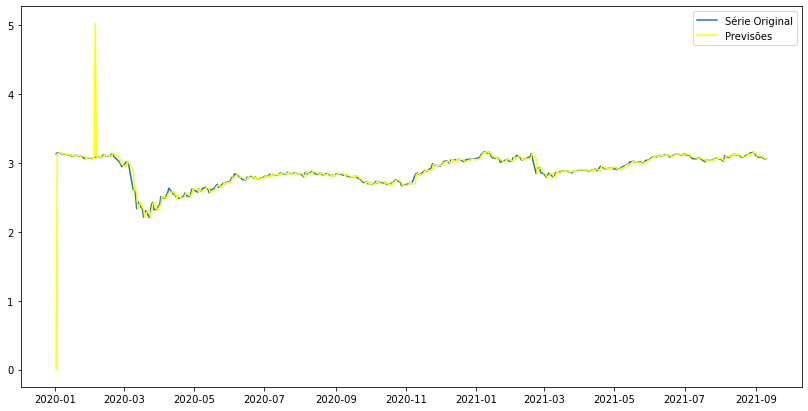

In [417]:
#Dados reais x previsão
dados_reais = df_treino_val_log
previsoes = modelo_sarima_v4_fit.fittedvalues

# Plot
plt.figure(figsize=(14, 7))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes, color = 'yellow', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

**A Série se ajustou bem aos dados de treino**

## Forecast dados de validação

In [418]:
# Forecast - Definir o numero de periodos a frente para ser previsto 

forecast_4 = modelo_sarima_v4_fit.get_forecast(len(df_valid_log))

In [419]:
#Criar intervalo de confiança

#Criar intervalos de confiança minimo e maximo
prev4 = forecast_4.conf_int()

#Criar a media dos intervalos de confiança = previsão
prev4['Mean'] = forecast_4.predicted_mean

#Criar o indice
prev4.index = df_valid_log.index
prev4

,lower High,upper High,Mean
Date,,,
2021-09-13,2.997878,3.127462,3.062670
2021-09-14,2.970268,3.153578,3.061923
2021-09-15,2.951046,3.175616,3.063331
2021-09-16,2.939039,3.198423,3.068731
2021-09-17,2.929862,3.219942,3.074902
...,...,...,...
2022-01-03,2.701140,3.730902,3.216021
2022-01-04,2.701402,3.736359,3.218881
2022-01-05,2.700714,3.740847,3.220780


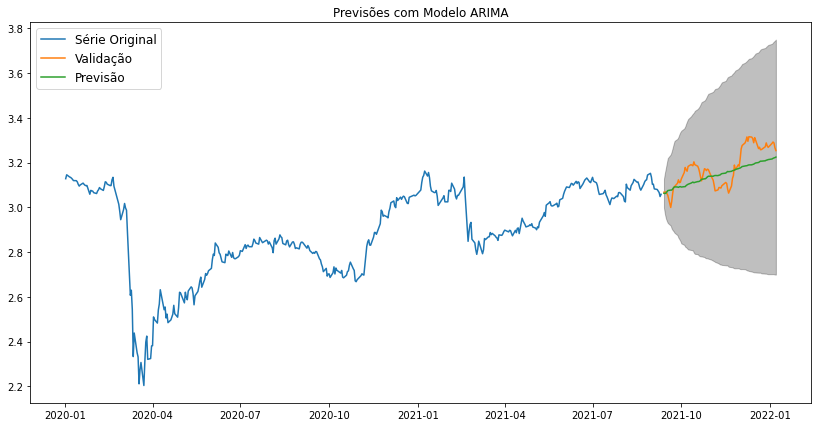

In [420]:
# Plot da Série Original, Validação e Previsão
plt.figure(figsize=(14, 7))
plt.plot(df_treino_val_log, label = 'Série Original')
plt.plot(df_valid_log, label = 'Validação')
plt.plot(prev4.Mean, label = 'Previsão')


plt.fill_between(prev4.index,
                prev4.iloc[:, 0],
                prev4.iloc[:, 1], color = 'k', alpha = .25)
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

**A previsão está ajustada com os dados de validação**

**OBS: A métrica RMSE parece ter um resultado mais satisfatório do que quando usamos a métrica AIC para a escolha dos melhores parâmetros**


## Análise dos Resíduos

In [425]:
#Média dos resíduos
modelo_sarima_v4_fit.resid.mean()

0.002248244957181684

**Média dos resíduos igual a Zero**

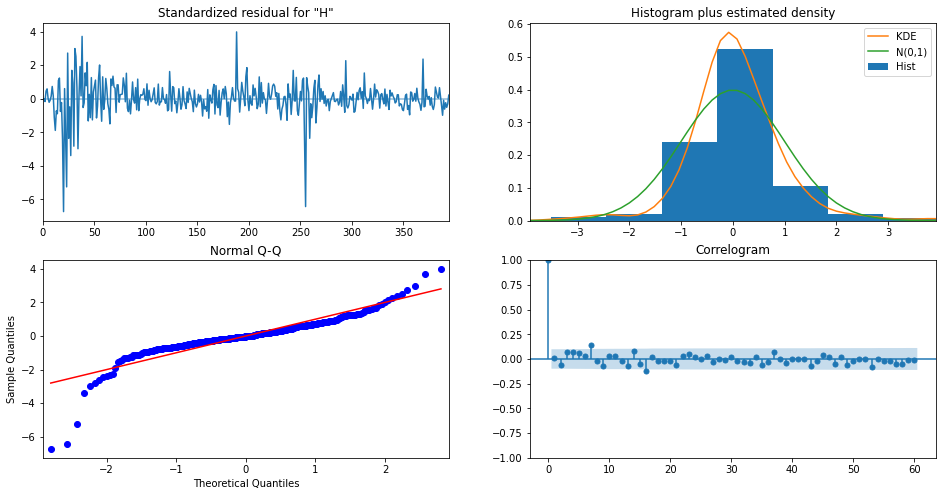

In [421]:
# Diagnóstico do modelo
modelo_sarima_v4_fit.plot_diagnostics(figsize = (16, 8),lags=60)
plt.show()

**Analisando o Histograma e o gráfico QQ-plot dos ruídos, os dados aparentam ter uma distribuição normal, e o gráfico do correlograma apresenta apenas 1 ponto estatisticamente significante de autocorrelação**

In [422]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_sarima_v4_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [1.57228435e-05]


**Observe que o valor-p é menor que 0.05, o que indica que os valores não são aleatórios e independentes ao longo do tempo a um nível de significância de 95% e, portanto, o modelo não fornece bom ajuste**

# Previsão com dados de teste

In [441]:
# Cria o Modelo SARIMA
modelo_final = sm.tsa.statespace.SARIMAX(df_treino_log,
                                             order = (1, 0, 0),
                                             seasonal_order = (1, 0,1, 24),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

# Treinamento (Fit) do modelo
modelo_final_fit = modelo_final.fit()
modelo_final_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 High   No. Observations:                  500
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 24)   Log Likelihood                 963.544
Date:                              Fri, 06 May 2022   AIC                          -1919.087
Time:                                      15:12:51   BIC                          -1902.434
Sample:                                           0   HQIC                         -1912.538
                                              - 500                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0006      0.001   1887.724      0.000       1.000       1.002
ar.S.L24       0.6259      0.037     16.900      0.000       0.553       0.698
ma.S.L24      -0.7456      0.036    -20.690      0.000      -0.816      -0.675
sigma2         0.0010   2.89e-05     33.647      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              3314.16
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [442]:
# Forecast - Definir o numero de periodos a frente para ser previsto 

forecast_test = modelo_final_fit.get_forecast(len(df_teste_log))

#Criar intervalo de confiança

#Criar intervalos de confiança minimo e maximo
prev_test = forecast_test.conf_int()

#Criar a media dos intervalos de confiança = previsão
prev_test['Mean'] = forecast_test.predicted_mean

#Criar o indice
prev_test.index = df_teste_log.index
prev_test

,lower High,upper High,Mean
Date,,,
2022-01-10,3.192481,3.314689,3.253585
2022-01-11,3.168909,3.341788,3.255349
2022-01-12,3.151394,3.363188,3.257291
2022-01-13,3.134412,3.379041,3.256726
2022-01-14,3.127909,3.401492,3.264700
...,...,...,...
2022-04-18,2.925947,3.854757,3.390352
2022-04-19,2.925364,3.859849,3.392606
2022-04-20,2.924854,3.864987,3.394920


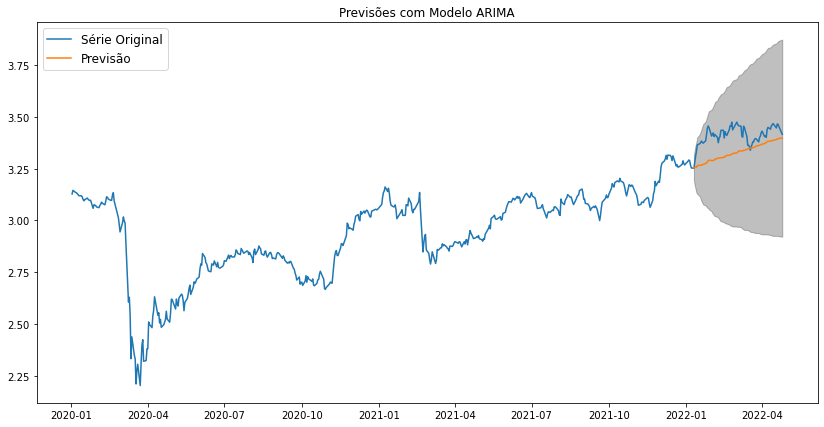

In [443]:
# Plot da Série Original, Validação e Previsão
plt.figure(figsize=(14, 7))
plt.plot(df_log, label = 'Série Original')


plt.plot(prev_test.Mean, label = 'Previsão')


plt.fill_between(prev_test.index,
                prev_test.iloc[:, 0],
                prev_test.iloc[:, 1], color = 'k', alpha = .25)
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

**Como podemos observar a previsão com os dados de treino e teste alcançou um bom resultado**

# Conclusão:

**O principal objetivo da previsão em uma série temporal é garantir que os resíduos do modelo não sejam correlacionados e sejam normalmente distribuídos com média zero**

**Para escolher os melhores parâmetros para o algoritimo SARIMAX utilizamos o auto_arima para ter o primeiro modelo base, depois usamos o GridSeach para otimizar os valores dos parâmetros usando as metricas RMSE e AIC**

**Como resultado final conseguimos o melhor modelo otimizando os parâmetros com a métrica RMSE, porém o modelo ARIMA no mini-projeto anterior ficou bem próximo deste modelo, pois a série temporal não tem uma sazonalidade clara nos dados**

**Poderíamos fazer mais combinações com Grid Search e ter tratado mais os dados, porém para fins didáticos o objetivo foi alcançado**
